In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# Load and pick Datas

In [2]:
# 读取训练集和测试集为 DataFrame
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print train_data.shape
display(train_data.head(1))
# display(train_data.info())

print test_data.shape
display(test_data.head(1))
# display(test_data.info())
train_length = train_data.shape[0]

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


In [3]:
# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Filling up missing values

In [4]:
def conbine_train_test_data():
    train_data2 = train_data.drop('SalePrice', axis=1)
    return pd.concat([train_data2, test_data])

conbined_data = conbine_train_test_data()
conbined_data.shape

(2919, 80)

In [5]:
# 存在缺失数据的列名
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# 每列包含多少缺失数据
conbined_data[has_null_columns].isnull().sum()

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [6]:
def fill_missing_conbined_data(column, value):
    conbined_data.loc[conbined_data[column].isnull(),column] = value

** LotFrontage/LotArea **

对于缺失的 LotFrontage，一般采用平均值进行填充，但考虑到可能与 LotArea 存在关系。

In [7]:
# Compute pairwise correlation of columns, excluding NA/null values
conbined_data['LotFrontage'].corr(conbined_data['LotArea'])

0.48989557038716691

LotArea: Lot size in square feet。LotArea 平方英尺为单位。考虑单位同一将 LotArea 进行 `sqrt()`

In [8]:
conbined_data['SqrtLotArea'] = np.sqrt(conbined_data['LotArea'])
conbined_data['LotFrontage'].corr(conbined_data['SqrtLotArea'])

0.64765803986178294

相关系数为 0.64765803986178294，说明 LotFrontage 与 LotArea 之间存在一定的正相关。下面对LotFrontage 与 LotArea 进行拟合。 

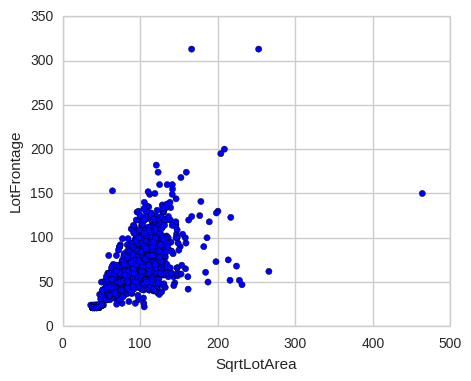

In [9]:
# 绘制 LotFrontage 与 LotArea 原始数据
lot_datas = conbined_data[['LotFrontage','SqrtLotArea']].dropna()
plt.figure(figsize=(5,4))
plt.scatter(lot_datas['SqrtLotArea'], lot_datas['LotFrontage'])
plt.xlabel("SqrtLotArea") 
plt.ylabel("LotFrontage") 

In [10]:
from sklearn.linear_model import LinearRegression

# Create linear regression object
regr = LinearRegression()

In [11]:
lotFrontage = lot_datas.iloc[:,0].values
sqrtLotArea = lot_datas.iloc[:,1].values

length = lotFrontage.shape[0]
lotFrontage = lotFrontage.reshape(length, 1)
sqrtLotArea = sqrtLotArea.reshape(length, 1)

# Train the model using the training sets
regr.fit(sqrtLotArea, lotFrontage)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
# The coefficients
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([[ 0.6430147]]))


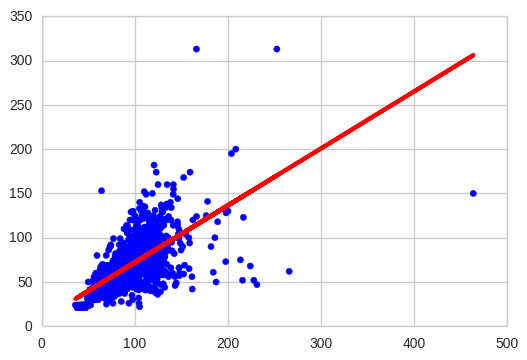

In [13]:
plt.scatter(sqrtLotArea, lotFrontage,  color='blue')
plt.plot(sqrtLotArea, regr.predict(sqrtLotArea), color='red',
         linewidth=3)

In [14]:
column = conbined_data['LotFrontage'].isnull()
conbined_data['LotFrontage'][column] = conbined_data['SqrtLotArea'][column].\
                                    map(lambda sqrt_lotarea : regr.predict(sqrt_lotarea)[0][0])

In [15]:
conbined_data[conbined_data['LotFrontage'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SqrtLotArea


In [16]:
conbined_data.drop('SqrtLotArea', axis=1, inplace=True)
conbined_data.shape

(2919, 80)

** Alley **

In [17]:
conbined_data.shape, conbined_data[conbined_data['Alley'].isnull()].shape

((2919, 80), (2721, 80))

2919 条数据缺失 2721 条，缺失数据过多(93.2%),将缺失数据填充为 NA（NA->No alley access）。

In [18]:
fill_missing_conbined_data('Alley', 'NA')
conbined_data[conbined_data['Alley'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


** MasVnrType / MasVnrArea **

方形单板砌体类型/面积，将缺失数据填充为出现次数最多的类型

In [19]:
conbined_data['MasVnrType'].fillna('None', inplace=True)
conbined_data['MasVnrArea'].fillna(0, inplace=True)

In [20]:
conbined_data['MasVnrType'].isnull().sum(), conbined_data['MasVnrArea'].isnull().sum()

(0, 0)

** BsmtQual / BsmtCond / BsmtExposure / BsmtFinType1 / BsmtFinType2 **

缺失 37 / 38 条数据。

In [21]:
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

In [22]:
# 对于缺失的字符串类型的数据填充为 NA，表示 No Basement
for column in basement_cols:
    if 'FinSF'not in column:
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')

In [23]:
# 对于数值型的 BsmtFinSF1 和 BsmtFinSF2
fill_missing_conbined_data('BsmtFinSF1', 0)
fill_missing_conbined_data('BsmtFinSF2', 0)

In [24]:
conbined_data[basement_cols].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtFinSF1      0
BsmtFinSF2      0
dtype: int64

** Electrical **

缺失一条数据,填充为出现次数最多的。

In [25]:
fill_missing_conbined_data('Electrical', conbined_data['Electrical'].max())

** FireplaceQu **

缺失 1420 条数据
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality

所以 FireplaceQu 与 Fireplaces 有关系

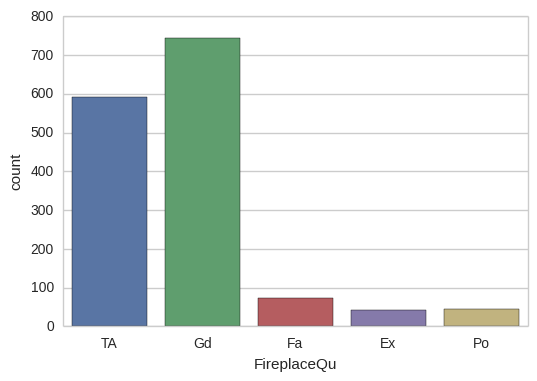

In [26]:
conbined_data['FireplaceQu'].value_counts()
conbined_data[['FireplaceQu', 'Fireplaces']].groupby(['FireplaceQu']).median()
sns.countplot(conbined_data['FireplaceQu'])

In [27]:
# 对于 Fireplaces 为 0 的，FireplaceQu 设置为 NA，表示 No Fireplace，此即缺失的 1420 条数据的情况
fill_missing_conbined_data('FireplaceQu', 'NA')

** PoolQC **

PoolQC 缺失 2909 条数据，是否与 PoolArea 有关。

In [28]:
fill_missing_conbined_data('PoolQC', 'NA')

** MiscFeature **

In [29]:
fill_missing_conbined_data('MiscFeature', 'NA')

** Fence **

In [30]:
fill_missing_conbined_data('Fence', 'NA')

** Garages **

In [31]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
conbined_data[garage_cols][conbined_data['GarageType'].isnull()==True].head(1)

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [32]:
# 对于缺失的字符串类型的数据填充为 NA，表示 No Garage
for column in garage_cols:
    if column != 'GarageCars' and column != 'GarageArea':
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')
    else:
        fill_missing_conbined_data(column, 0)

** MSZoning **

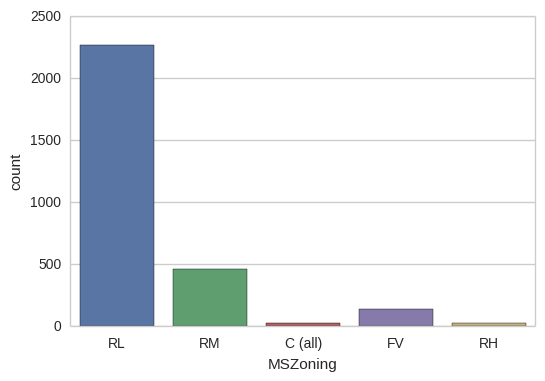

In [33]:
sns.countplot(conbined_data['MSZoning'])

In [34]:
conbined_data['MSZoning'].max()

'RM'

In [35]:
fill_missing_conbined_data('MSZoning', conbined_data['MSZoning'].max())

** Utilities **

In [36]:
fill_missing_conbined_data('Utilities', conbined_data['Utilities'].max())

** Exterior1st / Exterior2nd**

In [37]:
fill_missing_conbined_data('Exterior1st', conbined_data['Exterior1st'].max())

In [38]:
fill_missing_conbined_data('Exterior2nd', conbined_data['Exterior2nd'].max())

** BsmtUnfSF / TotalBsmtSF **

BsmtUnfSF: Unfinished square feet of basement area<br/>
BsmtFinSF2: Type 2 finished square feet<br/>
BsmtFinSF1: Type 1 finished square feet<br/>
TotalBsmtSF: Total square feet of basement area

测试发现：`TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF`

In [39]:
regr = LinearRegression()
bsmt_data = conbined_data[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']].dropna()

In [40]:
bsmt_x = bsmt_data.iloc[:,0:-1].values
bsmt_y = bsmt_data.iloc[:,-1].values

length = bsmt_x.shape[0]
bsmt_y = bsmt_y.reshape(length, 1)

# Train the model using the training sets
regr.fit(bsmt_x, bsmt_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
# The coefficients
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([[ 1.,  1.,  1.]]))


In [42]:
conbined_data[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']][conbined_data['BsmtUnfSF'].isnull()]

,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF
660,NaN,0.0,0.0,NaN


In [43]:
# 可以发现，对于缺失的 TotalBsmtSF 和 BsmtUnfSF 填充为0
fill_missing_conbined_data('BsmtUnfSF', 0)
fill_missing_conbined_data('TotalBsmtSF', 0)

** BsmtFullBath / BsmtHalfBath **

BsmtFullBath: Basement full bathrooms<br/>
BsmtHalfBath: Basement half bathrooms<br/>
FullBath: Full bathrooms above grade<br/>
HalfBath: Half baths above grade

In [44]:
conbined_data['FullBath'].corr(conbined_data['BsmtFullBath'])

-0.018815125742370497

In [45]:
fill_missing_conbined_data('BsmtFullBath', 0)
fill_missing_conbined_data('BsmtHalfBath', 0)

** KitchenQual **

KitchenAbvGr: Kitchens above grade<br/>
KitchenQual: Kitchen quality

In [46]:
print conbined_data['KitchenQual'].max()
conbined_data[['KitchenAbvGr', 'KitchenQual']].groupby('KitchenQual').mean()

TA


,KitchenAbvGr
KitchenQual,
Ex,1.000000
Fa,1.128571
Gd,1.004344
TA,1.077748


In [47]:
# 差别并不大，填充为1
fill_missing_conbined_data('KitchenQual', conbined_data['KitchenQual'].max())

** SaleType / Functional **

In [48]:
fill_missing_conbined_data('SaleType', conbined_data['SaleType'].max())
fill_missing_conbined_data('Functional', conbined_data['Functional'].max())

完成了缺失数据的填充。

In [49]:
# 存在缺失数据的列名
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# 每列包含多少缺失数据
conbined_data[has_null_columns].isnull().sum()

Series([], dtype: float64)

# Feature Engineering

** 时间属性（YearBuilt、GarageYrBlt）**

In [50]:
built_year_data = conbined_data[['YearBuilt', 'GarageYrBlt']][conbined_data['GarageYrBlt'] != 'NA']

In [51]:
built_year_data['GarageYrBlt'] = built_year_data['GarageYrBlt'].map(lambda g : int(g))
built_year_data['GarageYrBlt'].corr(built_year_data['YearBuilt'])

0.83481237316310175

可以发现 YearBuilt、GarageYrBlt 之间存在很高的相关性。

In [52]:
built_year_data.head(1)

,YearBuilt,GarageYrBlt
0,2003,2003


('Coefficients: \n', array([[ 0.72418557]]))


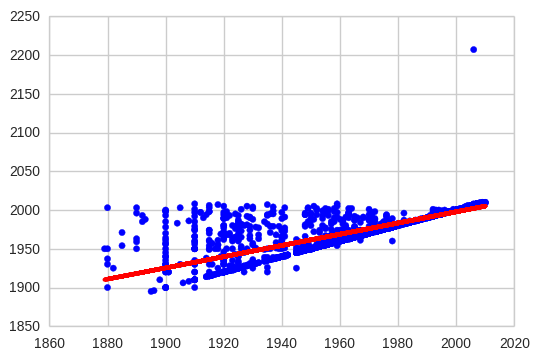

In [53]:
regr = LinearRegression()
garage_year = built_year_data.loc[:,'GarageYrBlt'].values
built_year = built_year_data.loc[:,'YearBuilt'].values

length = garage_year.shape[0]
garage_year = garage_year.reshape(length, 1)
built_year = built_year.reshape(length, 1)

# Train the model using the training sets
regr.fit(built_year, garage_year)
plt.scatter(built_year, garage_year,  color='blue')
plt.plot(built_year, regr.predict(built_year), color='red',
         linewidth=3)

# The coefficients
print('Coefficients: \n', regr.coef_)

In [54]:
# 对于 NA 的 GarageYrBlt，进行填充
conbined_data['GarageYrBlt'] = conbined_data.apply(lambda row : regr.predict(row['YearBuilt'])
                                                      if row['GarageYrBlt'] == 'NA' else row['GarageYrBlt'],
                                                       axis=1)

conbined_data['GarageYrBlt'] = conbined_data['GarageYrBlt'].map(lambda g : float(g))

In [55]:
conbined_data['GarageYrBlt'].head()

0    2003.0
1    1976.0
2    2001.0
3    1998.0
4    2000.0
Name: GarageYrBlt, dtype: float64

YearBuilt建造时间，YearRemodAdd修建时间，确定是否翻新改造过

In [56]:
conbined_data['RemodYears'] = conbined_data['YearRemodAdd'] - conbined_data['YearBuilt']

In [57]:
conbined_data['GarageBltYears'] = conbined_data['GarageYrBlt'] - conbined_data['YearBuilt']

In [58]:
conbined_data['GarageBltYears'].head()

0     0.0
1     0.0
2     0.0
3    83.0
4     0.0
Name: GarageBltYears, dtype: float64

In [59]:
# 距离现在建造的时间间隔
conbined_data['Now_YearBuilt'] = 2017 - conbined_data['YearBuilt']
conbined_data['Now_YearRemodAdd'] = 2017 - conbined_data['YearRemodAdd']
conbined_data['Now_GarageYrBlt'] = 2017 - conbined_data['GarageYrBlt']

conbined_data.drop('YearBuilt', axis=1, inplace=True)
conbined_data.drop('YearRemodAdd', axis=1, inplace=True)
conbined_data.drop('GarageYrBlt', axis=1, inplace=True)

In [60]:
conbined_data[['Now_YearBuilt','Now_YearRemodAdd','Now_GarageYrBlt']].head()

,Now_YearBuilt,Now_YearRemodAdd,Now_GarageYrBlt
0,14,14,14.0
1,41,41,41.0
2,16,15,16.0
3,102,47,19.0
4,17,17,17.0


房子卖的月份为数值类型，将其转为字符串类型

In [61]:
conbined_data['MoSold'] = conbined_data['MoSold'].map(lambda m : str(m))

In [62]:
conbined_data['MoSold'].head()

0     2
1     5
2     9
3     2
4    12
Name: MoSold, dtype: object

**对于 MSSubClass 的数值仅仅代表 the type of dwelling，所以将其编码。**

In [63]:
np.array(set(conbined_data['MSSubClass']))

array(set([160, 70, 40, 75, 45, 80, 50, 20, 30, 150, 120, 180, 90, 60, 190, 85]), dtype=object)

In [64]:
mssubclass_dict = {
    20: 'SC20',
    30: 'SC30',
    40: 'SC40',
    45: 'SC45',
    50: 'SC50',
    60: 'SC60',
    70: 'SC70',
    75: 'SC75',
    80: 'SC80',
    85: 'SC85',
    90: 'SC90',
    120: 'SC120',
    150: 'SC150',
    160: 'SC160',
    180: 'SC180',
    190: 'SC190',
}
conbined_data['MSSubClass'] = conbined_data['MSSubClass'].replace(mssubclass_dict)

In [65]:
np.array(set(conbined_data['MSSubClass']))

array(set(['SC20', 'SC30', 'SC50', 'SC40', 'SC150', 'SC90', 'SC85', 'SC160', 'SC80', 'SC120', 'SC190', 'SC75', 'SC70', 'SC60', 'SC180', 'SC45']), dtype=object)

对于那些存在大小特质的属性进行编码。

In [66]:
conbined_data = conbined_data.replace(
    {'Street': {'Grvl': 0, 'Pave': 1},
     'Alley': {'NA':0, 'Grvl': 1, 'Pave': 2},
     'Utilities': {'AllPub':3, 'NoSeWa': 1, 'NoSewr': 2, 'ELO': 0},
     'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,'NA': 0},
     'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'NA': 0},
     'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'NA': 0},
     'BsmtFinType1': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'BsmtFinType2': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'CentralAir': {'N':0, 'Y':1},
     'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
     'Functional': {'Typ':0,'Min1':1,'Min2':1,'Mod':2,'Maj1':3,'Maj2':4,'Sev':5,'Sal': 6},
     'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0},
     'Fence': {'GdPrv': 2, 'GdWo': 2, 'MnPrv': 1, 'MnWw': 1, 'NA': 0}
    })

Neighborhood 属性表示的是附近的地名，可将其转为经纬度。

In [67]:
# 纬度
conbined_data["latitude"] = conbined_data.Neighborhood.replace(
                                               {'Blmngtn' : 42.062806,
                                                'Blueste' : 42.009408,
                                                'BrDale' : 42.052500,
                                                'BrkSide': 42.033590,
                                                'ClearCr': 42.025425,
                                                'CollgCr': 42.021051,
                                                'Crawfor': 42.025949,
                                                'Edwards': 42.022800,
                                                'Gilbert': 42.027885,
                                                'GrnHill': 42.000854,
                                                'IDOTRR' : 42.019208,
                                                'Landmrk': 42.044777,
                                                'MeadowV': 41.991866,
                                                'Mitchel': 42.031307,
                                                'NAmes'  : 42.042966,
                                                'NoRidge': 42.050307,
                                                'NPkVill': 42.050207,
                                                'NridgHt': 42.060356,
                                                'NWAmes' : 42.051321,
                                                'OldTown': 42.028863,
                                                'SWISU'  : 42.017578,
                                                'Sawyer' : 42.033611,
                                                'SawyerW': 42.035540,
                                                'Somerst': 42.052191,
                                                'StoneBr': 42.060752,
                                                'Timber' : 41.998132,
                                                'Veenker': 42.040106})
# 经度
conbined_data["longitude"] = conbined_data.Neighborhood.replace(
                                               {'Blmngtn' : -93.639963,
                                                'Blueste' : -93.645543,
                                                'BrDale' : -93.628821,
                                                'BrkSide': -93.627552,
                                                'ClearCr': -93.675741,
                                                'CollgCr': -93.685643,
                                                'Crawfor': -93.620215,
                                                'Edwards': -93.663040,
                                                'Gilbert': -93.615692,
                                                'GrnHill': -93.643377,
                                                'IDOTRR' : -93.623401,
                                                'Landmrk': -93.646239,
                                                'MeadowV': -93.602441,
                                                'Mitchel': -93.626967,
                                                'NAmes'  : -93.613556,
                                                'NoRidge': -93.656045,
                                                'NPkVill': -93.625827,
                                                'NridgHt': -93.657107,
                                                'NWAmes' : -93.633798,
                                                'OldTown': -93.615497,
                                                'SWISU'  : -93.651283,
                                                'Sawyer' : -93.669348,
                                                'SawyerW': -93.685131,
                                                'Somerst': -93.643479,
                                                'StoneBr': -93.628955,
                                                'Timber' : -93.648335,
                                                'Veenker': -93.657032})

# Ames city 的经纬度：经度-93.63191310000002，纬度42.0307812，计算距离
conbined_data["NeighborDistance"] = np.sqrt(np.power((conbined_data["longitude"] - (-93.63191310000002)),2) + \
                                    np.power((conbined_data["latitude"] - 42.0307812),2))

display(conbined_data["NeighborDistance"].head())

0    0.054604
1    0.026794
2    0.054604
3    0.012657
4    0.031042
Name: NeighborDistance, dtype: float64

In [68]:
# Bin by neighborhood (a little arbitrarily). Values were computed by: 
neighbor_price_map = train_data["SalePrice"].groupby(train_data["Neighborhood"]).median().sort_values().to_dict()

In [69]:
neighbor_bin_map = {
    "MeadowV" : 0,  #  88000
    "IDOTRR" : 1,   # 103000
    "BrDale" : 1,   # 106000
    "OldTown" : 1,  # 119000
    "Edwards" : 1,  # 119500
    "BrkSide" : 1,  # 124300
    "Sawyer" : 1,   # 135000
    "Blueste" : 1,  # 137500
    "SWISU" : 2,    # 139500
    "NAmes" : 2,    # 140000
    "NPkVill" : 2,  # 146000
    "Mitchel" : 2,  # 153500
    "SawyerW" : 2,  # 179900
    "Gilbert" : 2,  # 181000
    "NWAmes" : 2,   # 182900
    "Blmngtn" : 2,  # 191000
    "CollgCr" : 2,  # 197200
    "ClearCr" : 3,  # 200250
    "Crawfor" : 3,  # 200624
    "Veenker" : 3,  # 218000
    "Somerst" : 3,  # 225500
    "Timber" : 3,   # 228475
    "StoneBr" : 4,  # 278000
    "NoRidge" : 4,  # 290000
    "NridgHt" : 4,  # 315000
}

conbined_data["NeighborPrice"] = conbined_data["Neighborhood"].map(neighbor_price_map)
conbined_data["NeighborBin"] = conbined_data["Neighborhood"].map(neighbor_bin_map)

# 去掉字符串类型的 Neighborhood
conbined_data.drop('Neighborhood', axis=1, inplace=True)
conbined_data.drop('latitude', axis=1, inplace=True)
conbined_data.drop('longitude', axis=1, inplace=True)

In [70]:
conbined_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,RemodYears,GarageBltYears,Now_YearBuilt,Now_YearRemodAdd,Now_GarageYrBlt,NeighborDistance,NeighborPrice,NeighborBin
0,1,SC60,RL,65.0,8450,1,0,Reg,Lvl,3,...,WD,Normal,0,0.0,14,14,14.0,0.054604,197200,2
1,2,SC20,RL,80.0,9600,1,0,Reg,Lvl,3,...,WD,Normal,0,0.0,41,41,41.0,0.026794,218000,3
2,3,SC60,RL,68.0,11250,1,0,IR1,Lvl,3,...,WD,Normal,1,0.0,16,15,16.0,0.054604,197200,2
3,4,SC70,RL,60.0,9550,1,0,IR1,Lvl,3,...,WD,Abnorml,55,83.0,102,47,19.0,0.012657,200624,3
4,5,SC60,RL,84.0,14260,1,0,IR1,Lvl,3,...,WD,Normal,0,0.0,17,17,17.0,0.031042,301500,4


# Create new features

Ref: [juliencs : A study on Regression applied to the Ames dataset
](https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset)
- Simplifications of existing features
- Combinations of existing features
- Polynomials on the top 10 existing features

In [71]:
# 1.Simplifications of existing features
conbined_data["SimplOverallQual"] = conbined_data.OverallQual.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, # bad
                                                             4 : 2, 5 : 2, 6 : 2, # average
                                                             7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                            })
conbined_data["SimplOverallCond"] = conbined_data.OverallCond.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, # bad
                                                             4 : 2, 5 : 2, 6 : 2, # average
                                                             7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                             })

In [72]:
# 2.Combinations of existing features

# Overall quality of the house
conbined_data["OverallGrade"] = conbined_data["OverallQual"] * conbined_data["OverallCond"]
# Overall quality of the garage
conbined_data["GarageGrade"] = conbined_data["GarageQual"] * conbined_data["GarageCond"]
# Overall quality of the exterior
conbined_data["ExterGrade"] = conbined_data["ExterQual"] * conbined_data["ExterCond"]
# Overall kitchen score
conbined_data["KitchenScore"] = conbined_data["KitchenAbvGr"] * conbined_data["KitchenQual"]
# Overall fireplace score
conbined_data["FireplaceScore"] = conbined_data["Fireplaces"] * conbined_data["FireplaceQu"]
# Overall garage score
conbined_data["GarageScore"] = conbined_data["GarageArea"] * conbined_data["GarageQual"]
# Overall pool score
conbined_data["PoolScore"] = conbined_data["PoolArea"] * conbined_data["PoolQC"]

# Total number of bathrooms
conbined_data["TotalBath"] = conbined_data["BsmtFullBath"] + (0.5 * conbined_data["BsmtHalfBath"]) + \
conbined_data["FullBath"] + (0.5 * conbined_data["HalfBath"])

# Total yard area in square feet
conbined_data["TotalPorchSF"] = conbined_data["OpenPorchSF"] + conbined_data["EnclosedPorch"] +\
                                conbined_data["3SsnPorch"] + conbined_data["ScreenPorch"]
# Total SF for house (living, basement, porch, pool)
conbined_data["AllSF"] = conbined_data["GrLivArea"] + conbined_data["TotalBsmtSF"] + \
                         conbined_data["TotalPorchSF"] + conbined_data["WoodDeckSF"] + \
                         conbined_data["PoolArea"]

# Has masonry veneer or not
conbined_data["HasMasVnr"] = conbined_data.MasVnrType.replace(
    {"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, "Stone" : 1, "None" : 0})
# House completed before sale or not
conbined_data["BoughtOffPlan"] = conbined_data.SaleCondition.replace(
    {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})

In [73]:
# 3.Polynomials on the top 10 existing features
train_data_new = conbined_data.iloc[:train_length,:]
# 添加价格
train_data_new.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ExterGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalBath,TotalPorchSF,AllSF,HasMasVnr,BoughtOffPlan
0,1,SC60,RL,65.0,8450,1,0,Reg,Lvl,3,...,6,3,0,1644.0,0,3.5,61,2627.0,1,0
1,2,SC20,RL,80.0,9600,1,0,Reg,Lvl,3,...,4,2,3,1380.0,0,2.5,0,2822.0,0,0
2,3,SC60,RL,68.0,11250,1,0,IR1,Lvl,3,...,6,3,3,1824.0,0,3.5,42,2748.0,1,0
3,4,SC70,RL,60.0,9550,1,0,IR1,Lvl,3,...,4,3,4,1926.0,0,2.0,307,2780.0,0,0
4,5,SC60,RL,84.0,14260,1,0,IR1,Lvl,3,...,6,3,3,2508.0,0,3.5,84,3619.0,1,0


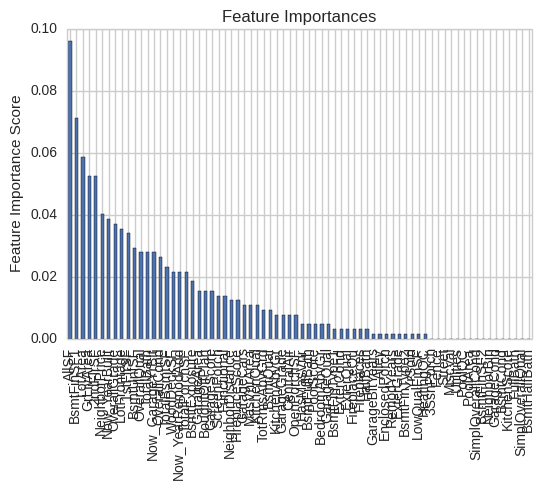

In [74]:
from xgboost import XGBRegressor

train_Y = train_data['SalePrice']
train_X = train_data_new.select_dtypes(exclude=['object']).drop(['Id'], axis=1)

xgb_regressor = XGBRegressor(seed=10)
xgb_regressor.fit(train_X, train_Y)

feature_importances = pd.Series(xgb_regressor.feature_importances_, train_X.columns.values)
feature_importances = feature_importances.sort_values(ascending=False)
# feature_importances= feature_importances.head(40)
feature_importances.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [75]:
# 3.Polynomials on the top 10 existing features
top_n = 10
poly_columns = feature_importances.index.values[:top_n]
for column in poly_columns:
    conbined_data[column+'-s2'] = conbined_data[column] ** 2
    conbined_data[column+'-s3'] = conbined_data[column] ** 3
    conbined_data[column+'-sq'] = np.sqrt(conbined_data[column])

In [76]:
conbined_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Now_YearBuilt-sq,OverallGrade-s2,OverallGrade-s3,OverallGrade-sq,LotFrontage-s2,LotFrontage-s3,LotFrontage-sq,1stFlrSF-s2,1stFlrSF-s3,1stFlrSF-sq
0,1,SC60,RL,65.0,8450,1,0,Reg,Lvl,3,...,3.741657,1225,42875,5.916080,4225.0,274625.0,8.062258,732736,627222016,29.257478
1,2,SC20,RL,80.0,9600,1,0,Reg,Lvl,3,...,6.403124,2304,110592,6.928203,6400.0,512000.0,8.944272,1592644,2009916728,35.524639
2,3,SC60,RL,68.0,11250,1,0,IR1,Lvl,3,...,4.000000,1225,42875,5.916080,4624.0,314432.0,8.246211,846400,778688000,30.331502
3,4,SC70,RL,60.0,9550,1,0,IR1,Lvl,3,...,10.099505,1225,42875,5.916080,3600.0,216000.0,7.745967,923521,887503681,31.000000
4,5,SC60,RL,84.0,14260,1,0,IR1,Lvl,3,...,4.123106,1600,64000,6.324555,7056.0,592704.0,9.165151,1311025,1501123625,33.837849


** Feature Scale / Skew **

Ref: [Lasso model for regression problem](https://www.kaggle.com/klyusba/house-prices-advanced-regression-techniques/lasso-model-for-regression-problem/notebook)

In [77]:
numeric_feats = conbined_data.select_dtypes(exclude=['object']).columns.values[1:]

t = conbined_data[numeric_feats].quantile(.95)
use_max_scater = t[t == 0].index
use_95_scater = t[t != 0].index
conbined_data[use_max_scater] = conbined_data[use_max_scater] / conbined_data[use_max_scater].max()
conbined_data[use_95_scater] = conbined_data[use_95_scater] / conbined_data[use_95_scater].quantile(.95)

In [78]:
# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
from scipy.stats import skew

skewed = conbined_data[numeric_feats].apply(lambda x: skew(x.astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
print 'skewed features', skewed.shape[0],' from total ',conbined_data.shape[1],' features'
conbined_data[skewed] = np.log1p(conbined_data[skewed])

skewed features 60  from total  128  features


** Dummy Encoding **

In [79]:
conbined_data = pd.get_dummies(conbined_data)

In [80]:
conbined_data.head(2)

,Id,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,0.474666,0.400731,1.0,0.0,1.0,0.875,0.625,0.35108,0.693147,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.558280,0.444685,1.0,0.0,1.0,0.750,1.000,0.00000,0.510826,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Delete some features to prevent overfitting.

![](http://itknowledgeexchange.techtarget.com/writing-for-business/files/2012/12/skewness-300x247.png)

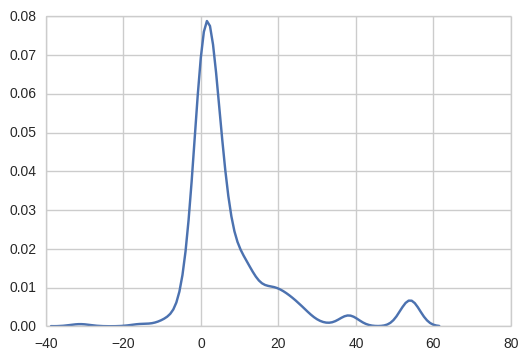

In [81]:
sns.kdeplot(skew(conbined_data))

In [82]:
# for features who's abs(skew) > 40,delete them to prevent over-fitting
delete_features = conbined_data.columns.values[np.abs(skew(conbined_data)) > 40]

conbined_data.drop(delete_features, axis=1, inplace=True)
print 'delete ', delete_features.shape[0], ' features:'
print delete_features

delete  12  features:
['MSSubClass_SC150' 'Condition2_RRAe' 'Condition2_RRAn' 'RoofMatl_ClyTile'
 'RoofMatl_Membran' 'RoofMatl_Metal' 'RoofMatl_Roll' 'Exterior1st_ImStucc'
 'Exterior2nd_Other' 'Heating_Floor' 'Electrical_Mix' 'MiscFeature_TenC']


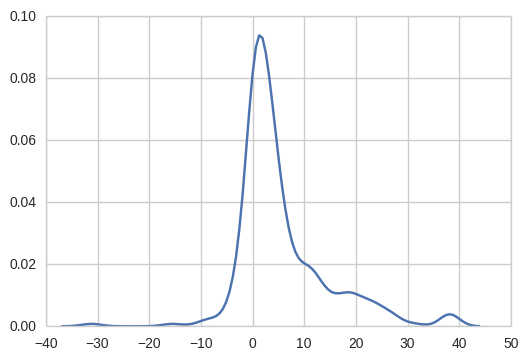

In [83]:
sns.kdeplot(skew(conbined_data))

In [84]:
conbined_data.head()

,Id,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,0.474666,0.400731,1.0,0.0,1.0,0.875,0.625,0.351080,0.693147,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.558280,0.444685,1.0,0.0,1.0,0.750,1.000,0.000000,0.510826,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,0.491957,0.504555,1.0,0.0,1.0,0.875,0.625,0.298355,0.693147,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,0.445165,0.442814,1.0,0.0,1.0,0.875,0.625,0.000000,0.510826,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,0.579445,0.605316,1.0,0.0,1.0,1.000,0.625,0.560229,0.693147,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [85]:
train_X = conbined_data.iloc[:train_length, 1:]
train_Y = train_data['SalePrice']
train_Id = conbined_data.iloc[:train_length, 0]

test_X = conbined_data.iloc[train_length:, 1:]
test_Id = conbined_data.iloc[train_length:, 0]

print("train_X : " + str(train_X.shape))
print("test_X : " + str(test_X.shape))
print("train_Y : " + str(train_Y.shape))

train_X : (1460, 269)
test_X : (1459, 269)
train_Y : (1460,)


(array([   5.,   12.,   54.,  184.,  470.,  400.,  220.,   90.,   19.,    6.]),
 array([ 10.46027076,  10.76769112,  11.07511148,  11.38253184,
         11.6899522 ,  11.99737256,  12.30479292,  12.61221328,
         12.91963363,  13.22705399,  13.53447435]),
 <a list of 10 Patch objects>)

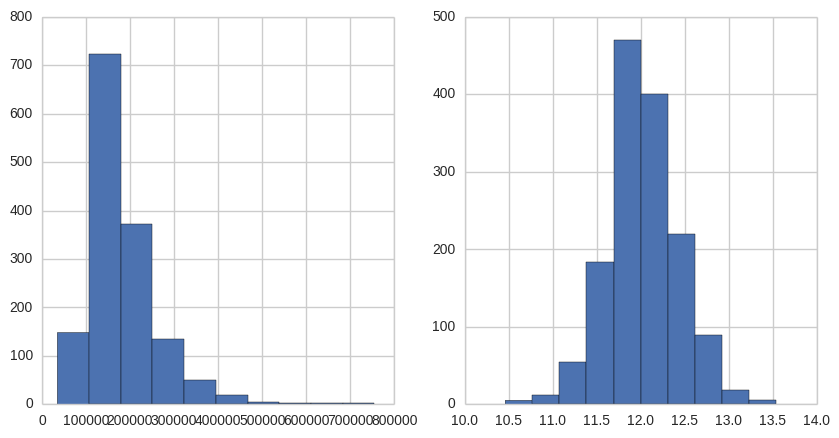

In [86]:
# 价格分布
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
axis1.hist(train_Y)
# Transform skewed numeric features using log(p+1) transformation making them more normal
train_Y = np.log1p(train_Y)
axis2.hist(train_Y)

# Save New Data

In [87]:
save_train = train_X.copy()
save_test = test_X.copy()
save_train['Id'] = train_Id
save_train['SalePrice'] = train_Y
save_test['Id'] = test_Id

display(save_train.head())
display(save_test.head())

save_train.to_csv("data/new_train.csv", index=False)
save_test.to_csv("data/new_test.csv", index=False)

,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id,SalePrice
0,0.474666,0.400731,1.0,0.0,1.0,0.875,0.625,0.351080,0.693147,0.510826,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,12.247699
1,0.558280,0.444685,1.0,0.0,1.0,0.750,1.000,0.000000,0.510826,0.510826,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,12.109016
2,0.491957,0.504555,1.0,0.0,1.0,0.875,0.625,0.298355,0.693147,0.510826,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,12.317171
3,0.445165,0.442814,1.0,0.0,1.0,0.875,0.625,0.000000,0.510826,0.510826,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4,11.849405
4,0.579445,0.605316,1.0,0.0,1.0,1.000,0.625,0.560229,0.693147,0.510826,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5,12.429220


,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id
0,0.558280,0.517572,1.0,0.0,1.0,0.625,0.750,0.000000,0.510826,0.510826,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1461
1,0.563613,0.605539,1.0,0.0,1.0,0.750,0.750,0.208444,0.510826,0.510826,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1462
2,0.525668,0.591529,1.0,0.0,1.0,0.625,0.625,0.000000,0.510826,0.510826,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1463
3,0.547527,0.458721,1.0,0.0,1.0,0.750,0.750,0.042023,0.510826,0.510826,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1464
4,0.337806,0.256159,1.0,0.0,1.0,1.000,0.625,0.000000,0.693147,0.510826,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1465
